In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from scipy.optimize import minimize;

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

In [2]:
data_train_orig = pd.read_csv('train.csv',parse_dates=['date_time'],index_col='date_time')
data_test_orig = pd.read_csv('test.csv',parse_dates=['date_time'],index_col='date_time')
sample_submission = pd.read_csv('sample_submission.csv');
target_cols = ['target_carbon_monoxide','target_benzene','target_nitrogen_oxides'];
feature_cols = list(data_test_orig.columns);

In [3]:
def munge(df):
    df['date'] = df.index.date;
    df['month'] = df.index.to_numpy().astype('datetime64[M]');
    df['month'] = df['month'].dt.month;
    df['hours'] = (df.index-pd.to_datetime('2010-03-10')) / np.timedelta64(1,'h');
    df['hour'] = df['hours'].apply(lambda h:int(h)%24);

    df['day'] = (df.index-pd.to_datetime('2010-03-10')) / np.timedelta64(1,'D');
    df['day'] = df['day'].astype(int);

    df['day_of_week'] = df.index.dayofweek;

    df['hours'] = (df.index-pd.to_datetime('2010-03-10')) / np.timedelta64(1,'h');
    df['hours'] = df['hours'].astype('float');
    
    df['bad_data'] = df['sensor_4'] < 650;
    return df;

In [4]:
data_train = data_train_orig.copy();
data_train = munge(data_train);
#data_train = data_train.loc[data_train.index[~data_train['bad_data']]]

data_test = data_test_orig.copy();
data_test = munge(data_test);

In [5]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputRegressor

transform_forward = np.log1p; transform_backward = np.expm1;

def calc_loss(ypred,y):
    errs = np.log1p(ypred) - np.log1p(y);
    return np.mean(np.sqrt(np.sum(np.power(errs,2))/len(y)));

def removeBadEntries(X,y):
    keep_idx = X.index[~X['bad_data']];
    Xnew = X.loc[keep_idx];
    #Xnew = Xnew.drop(['bad_data'],axis=1);
    ynew = y.loc[keep_idx];
    return Xnew,ynew;
def setBadEntries(X_orig,y_whole):
    y_post = pd.DataFrame(y_whole,index=X_orig.index);
    y_post.loc[X_orig['bad_data']] = 0.1;
    y_post = y_post.values.flatten();
    return y_post;

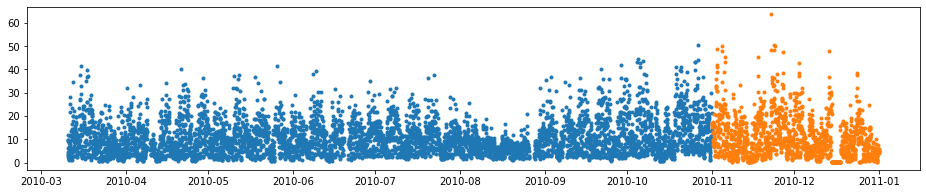

In [6]:
X_train = data_train.drop(target_cols,axis=1).select_dtypes(exclude='object').copy();
X_train[feature_cols] = np.log(X_train[feature_cols]);
y_train = data_train['target_benzene'];

X_test = data_test.select_dtypes(exclude='object').copy();
X_test[feature_cols] = np.log(X_test[feature_cols]);

res_train = X_train.index < '2010-11-01'; res_valid = ~res_train;

X = X_train.iloc[res_train]; y = y_train[res_train];
X,y = removeBadEntries(X,y);
X_valid = X_train.iloc[res_valid]; y_valid = y_train[res_valid];

plt.figure(figsize=(16,3))
#plt.plot(X_train.index,y_train);
plt.plot(X.index,y,'.');
plt.plot(X_valid.index,y_valid,'.');

In [7]:
gammas = np.linspace(.001,.4,50);
losses = np.zeros( (len(gammas),2) );

for jj,gamma in enumerate(gammas):
    myModel = XGBRegressor(gamma=gamma);

    myModel.fit(X,transform_forward(y));
    y_pred_xgb= transform_backward(myModel.predict(X));
    y_valid_pred_xgb = transform_backward(myModel.predict(X_valid));

    y_valid_pred_xgb = setBadEntries(X_valid,y_valid_pred_xgb);
    
    losses[jj,0] = calc_loss(y_pred_xgb,y);
    losses[jj,1] = calc_loss(y_valid_pred_xgb,y_valid);

0.06614285714285714


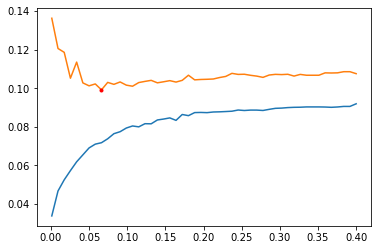

In [9]:
plt.plot(gammas,losses);

min_ind = np.argmin(losses[:,1]);
plt.plot(gammas[min_ind],losses[min_ind,1],'r.');
print(gammas[min_ind])

In [10]:
myXGB = XGBRegressor(gamma=.066);

myXGB.fit(X,transform_forward(y));
y_pred_xgb= transform_backward(myXGB.predict(X));
y_valid_pred_xgb = transform_backward(myXGB.predict(X_valid));

y_valid_pred_xgb = setBadEntries(X_valid,y_valid_pred_xgb);

print('training loss   = %0.6f'%(calc_loss(y_pred_xgb,y)))
print('validation loss = %0.6f'%(calc_loss(y_valid_pred_xgb,y_valid)))

training loss   = 0.072776
validation loss = 0.098846


In [12]:
from sklearn.model_selection import KFold

NNs = [5,10,15,20,25,30,35];
losses = np.zeros( (len(NNs),2) );

for jj,N_FOLDS in enumerate(NNs):

    #N_FOLDS = 25;
    myKFold = KFold(n_splits=N_FOLDS);

    y_valid_pred = np.zeros( (len(X_valid)) );
    y_valid_pred_mult = np.ones( (len(X_valid)) );
    
    for idx_fold, idx_oof in myKFold.split(X,y):

        X_fold = X.iloc[idx_fold]; X_oof = X.iloc[idx_oof];
        y_fold = y.iloc[idx_fold]; y_oof = y.iloc[idx_oof];

        myXGB.fit(X_fold,transform_forward(y_fold));

        y_fold_pred_xgb  = transform_backward(myXGB.predict(X_fold));
        y_oof_pred_xgb  = transform_backward(myXGB.predict(X_oof));
        y_valid_pred_xgb  = transform_backward(myXGB.predict(X_valid));
        y_valid_pred_xgb = setBadEntries(X_valid,y_valid_pred_xgb);

        print('XGB  fold loss   = %0.6f  oof loss = %0.6f  valid loss = %0.6f'%( calc_loss(y_fold_pred_xgb,y_fold),
                                                                                 calc_loss(y_oof_pred_xgb,y_oof),
                                                                                 calc_loss(y_valid_pred_xgb,y_valid) ));

        y_valid_pred += y_valid_pred_xgb / N_FOLDS;
        y_valid_pred_mult *= np.power(y_valid_pred_xgb,1./N_FOLDS);
    print(calc_loss(y_valid_pred,y_valid));
    print(calc_loss(y_valid_pred_mult,y_valid));
    losses[jj,0] = calc_loss(y_valid_pred,y_valid);
    losses[jj,1] = calc_loss(y_valid_pred_mult,y_valid);

XGB  fold loss   = 0.073186  oof loss = 0.100557  valid loss = 0.098731
XGB  fold loss   = 0.074079  oof loss = 0.095524  valid loss = 0.102744
XGB  fold loss   = 0.076105  oof loss = 0.090124  valid loss = 0.100559
XGB  fold loss   = 0.075142  oof loss = 0.096159  valid loss = 0.104610
XGB  fold loss   = 0.073364  oof loss = 0.092946  valid loss = 0.114127
0.09997242460213782
0.09989716884956566
XGB  fold loss   = 0.072202  oof loss = 0.095354  valid loss = 0.105611
XGB  fold loss   = 0.071711  oof loss = 0.098643  valid loss = 0.117247
XGB  fold loss   = 0.073046  oof loss = 0.091749  valid loss = 0.103622
XGB  fold loss   = 0.074476  oof loss = 0.098817  valid loss = 0.103553
XGB  fold loss   = 0.072314  oof loss = 0.086587  valid loss = 0.106848
XGB  fold loss   = 0.074868  oof loss = 0.090353  valid loss = 0.102747
XGB  fold loss   = 0.072757  oof loss = 0.093466  valid loss = 0.101726
XGB  fold loss   = 0.074217  oof loss = 0.091416  valid loss = 0.100127
XGB  fold loss   = 0.072

XGB  fold loss   = 0.072737  oof loss = 0.104549  valid loss = 0.101064
XGB  fold loss   = 0.074486  oof loss = 0.084890  valid loss = 0.101330
XGB  fold loss   = 0.072673  oof loss = 0.096260  valid loss = 0.099991
XGB  fold loss   = 0.074570  oof loss = 0.093334  valid loss = 0.100002
XGB  fold loss   = 0.074132  oof loss = 0.086985  valid loss = 0.100900
XGB  fold loss   = 0.072249  oof loss = 0.107074  valid loss = 0.101432
XGB  fold loss   = 0.072732  oof loss = 0.097796  valid loss = 0.110673
XGB  fold loss   = 0.071800  oof loss = 0.087784  valid loss = 0.103487
XGB  fold loss   = 0.072415  oof loss = 0.089544  valid loss = 0.101378
XGB  fold loss   = 0.074263  oof loss = 0.085072  valid loss = 0.102577
XGB  fold loss   = 0.073122  oof loss = 0.085046  valid loss = 0.106624
XGB  fold loss   = 0.072596  oof loss = 0.089398  valid loss = 0.104922
XGB  fold loss   = 0.073943  oof loss = 0.087086  valid loss = 0.101451
XGB  fold loss   = 0.073180  oof loss = 0.092858  valid loss = 0

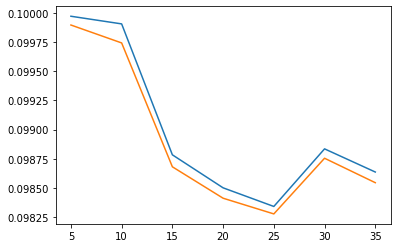

In [13]:
plt.plot(NNs,losses)

In [ ]:
from sklearn.model_selection import KFold

N_FOLDS = 25;
myKFold = KFold(n_splits=N_FOLDS);

y_valid_pred = np.ones( (len(X_valid)) );

for idx_fold, idx_oof in myKFold.split(X,y):
    X_fold = X.iloc[idx_fold]; X_oof = X.iloc[idx_oof];
    y_fold = y.iloc[idx_fold]; y_oof = y.iloc[idx_oof];

    myXGB.fit(X_fold,transform_forward(y_fold));

    y_fold_pred_xgb  = transform_backward(myXGB.predict(X_fold));
    y_oof_pred_xgb  = transform_backward(myXGB.predict(X_oof));
    y_valid_pred_xgb  = transform_backward(myXGB.predict(X_valid));
    y_valid_pred_xgb = setBadEntries(X_valid,y_valid_pred_xgb);
    
    print('XGB  fold loss   = %0.6f  oof loss = %0.6f  valid loss = %0.6f'%( calc_loss(y_fold_pred_xgb,y_fold),
                                                                             calc_loss(y_oof_pred_xgb,y_oof),
                                                                             calc_loss(y_valid_pred_xgb,y_valid) ));

    y_valid_pred *= np.power(y_valid_pred_xgb,1./N_FOLDS);
print(calc_loss(y_valid_pred,y_valid));

In [17]:
N_FOLDS = 25;
myKFold = KFold(n_splits=N_FOLDS);

y_test_pred = np.ones( (len(X_test)) );

for idx_fold, idx_oof in myKFold.split(X_train,y_train):

    X_fold = X_train.iloc[idx_fold]; X_oof = X_train.iloc[idx_oof];
    y_fold = y_train.iloc[idx_fold]; y_oof = y_train.iloc[idx_oof];

    myXGB.fit(X_fold,transform_forward(y_fold));

    y_fold_pred_xgb  = transform_backward(myXGB.predict(X_fold));
    y_oof_pred_xgb  = transform_backward(myXGB.predict(X_oof));
    #y_valid_pred_xgb  = transform_backward(myXGB.predict(X_valid));
    y_test_pred_xgb = transform_backward(myXGB.predict(X_test));
    y_test_pred_xgb = setBadEntries(X_test,y_test_pred_xgb);

    print('XGB  fold loss   = %0.6f  oof loss = %0.6f'%( calc_loss(y_fold_pred_xgb,y_fold),
                                                                             calc_loss(y_oof_pred_xgb,y_oof)));

    #y_valid_pred *= np.power(y_valid_pred_xgb, 1./N_FOLDS);
    y_test_pred *= np.power(y_test_pred_xgb, 1./N_FOLDS);

XGB  fold loss   = 0.072988  oof loss = 0.092664
XGB  fold loss   = 0.071770  oof loss = 0.092800
XGB  fold loss   = 0.073126  oof loss = 0.094975
XGB  fold loss   = 0.075665  oof loss = 0.104661
XGB  fold loss   = 0.072531  oof loss = 0.091566
XGB  fold loss   = 0.073324  oof loss = 0.090129
XGB  fold loss   = 0.072130  oof loss = 0.101936
XGB  fold loss   = 0.074171  oof loss = 0.089365
XGB  fold loss   = 0.073991  oof loss = 0.079474
XGB  fold loss   = 0.073192  oof loss = 0.084996
XGB  fold loss   = 0.072890  oof loss = 0.084757
XGB  fold loss   = 0.072447  oof loss = 0.088098
XGB  fold loss   = 0.076188  oof loss = 0.090388
XGB  fold loss   = 0.074996  oof loss = 0.098635
XGB  fold loss   = 0.073615  oof loss = 0.081828
XGB  fold loss   = 0.072864  oof loss = 0.085931
XGB  fold loss   = 0.073820  oof loss = 0.092536
XGB  fold loss   = 0.072836  oof loss = 0.087183
XGB  fold loss   = 0.072610  oof loss = 0.089519
XGB  fold loss   = 0.072505  oof loss = 0.083927
XGB  fold loss   = 0

In [23]:
benzene_predictions = pd.DataFrame(y_test_pred,index=X_test.index,columns=['target_benzene'])
benzene_predictions.to_csv('benzene_predictions.csv')